# **Detección de Fraude en Transacciones de Tarjetas de Crédito**


### **Definición del Problema**

El fraude con tarjetas de crédito representa una amenaza significativa para la integridad de las transacciones financieras y la confianza de los consumidores en el comercio digital. A medida que la dependencia de las tarjetas de crédito para las compras diarias continúa creciendo, también lo hace la sofisticación de los estafadores que explotan las vulnerabilidades del sistema. Este proyecto tiene como objetivo aplicar técnicas de aprendizaje automático para la detección de fraudes en transacciones de tarjetas de crédito.  A lo largo del proyecto, se sigue un flujo de análisis y desarrollo orientado a la clasificación de transacciones como fraudulentas (clase 1) o no fraudulentas (clase 0).

#### **Dataset**
- **Fuente**: [Kaggle - credit-card-fraud-detection](https://www.kaggle.com/datasets/bhadramohit/credit-card-fraud-detection)

- **Descripción**: El **Credit Card Fraud Dataset** es un conjunto de datos que comprende 100000 transacciones generadas para simular la actividad de las tarjetas de crédito en el mundo real. Cada entrada incluye las siguientes características:
    - **TransactionID**:  Un identificador único para cada transacción, que garantiza la trazabilidad.
    - **TransactionDate**: La fecha y hora en que se produjo la transacción, lo que permite el análisis temporal.
    - **Amount**: El valor monetario de la transacción, que puede ayudar a identificar transacciones inusualmente grandes que pueden indicar fraude.
    - **MerchantID**: Un identificador para el comerciante involucrado en la transacción, útil para evaluar patrones de fraude relacionados con el comerciante.
    - **TransactionType**: Indica si la transacción fue una compra o un reembolso, proporcionando contexto para la actividad.
    - **Location**: La ubicación geográfica de la transacción, lo que facilita el análisis de las tendencias de fraude por región.
    - **IsFraud**: Una variable objetivo binaria que indica si la transacción es fraudulenta (1) o legítima (0), esencial para los modelos de aprendizaje supervisado.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("./data/credit_card_fraud_dataset.csv")
data.head()

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0


In [3]:
data.info()
data.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


TransactionID      100000
TransactionDate    100000
Amount              90621
MerchantID           1000
TransactionType         2
Location               10
IsFraud                 2
dtype: int64

**Verificar valores nulos:**

In [4]:
data.isnull().sum()

TransactionID      0
TransactionDate    0
Amount             0
MerchantID         0
TransactionType    0
Location           0
IsFraud            0
dtype: int64

> El dataset no contiene valores nulos

**Verificar valores duplicados:**

In [5]:
data.duplicated().sum()

0

> El dataset no contiene valores duplicados

## **Análisis Exploratorio de Datos (EDA)**

**Estadísticas descriptivas generales:**

In [6]:
data.describe()

,TransactionID,Amount,MerchantID,IsFraud
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,2497.092666,501.676070,0.010000
std,28867.657797,1442.415999,288.715868,0.099499
min,1.000000,1.050000,1.000000,0.000000
25%,25000.750000,1247.955000,252.000000,0.000000
50%,50000.500000,2496.500000,503.000000,0.000000
75%,75000.250000,3743.592500,753.000000,0.000000
max,100000.000000,4999.770000,1000.000000,1.000000


**Distribución de la variable objetivo:**  `IsFraud`

Distribución de transacciones:
IsFraud
0    99000
1     1000
Name: count, dtype: int64

Porcentajes:
IsFraud
0    99.0
1     1.0
Name: proportion, dtype: float64


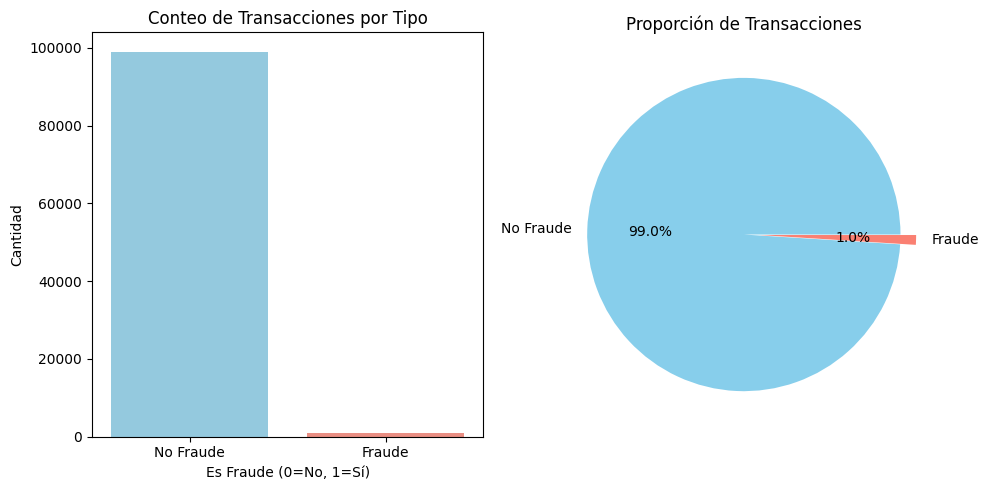

In [7]:
fraud_count = data['IsFraud'].value_counts()
fraud_percentage = data['IsFraud'].value_counts(normalize=True) * 100

print("Distribución de transacciones:")
print(fraud_count)
print("\nPorcentajes:")
print(fraud_percentage)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='IsFraud', data=data, hue='IsFraud', palette=['skyblue', 'salmon'], legend=False)
plt.title('Conteo de Transacciones por Tipo')
plt.xlabel('Es Fraude (0=No, 1=Sí)')
plt.ylabel('Cantidad')
plt.xticks([0, 1], ['No Fraude', 'Fraude'])  # Hacemos las etiquetas más descriptivas

plt.subplot(1, 2, 2)
plt.pie(fraud_count, labels=['No Fraude', 'Fraude'], autopct='%1.1f%%', 
        colors=['skyblue', 'salmon'], explode=(0, 0.1))
plt.title('Proporción de Transacciones')
plt.tight_layout()  
plt.show()

> El dataset está extremadamente desbalanceado: 99% (100000) transacciones legítimas vs 1% (100) fraudulentas.
> Se necesitará reducir el tamaño del dataset debido a que la diferencia es demasiado grande, además de aplicar técnicas especiales (oversampling, undersampling, class weighting) para manejar este desbalance.

**Análisis Temporal del Fraude**

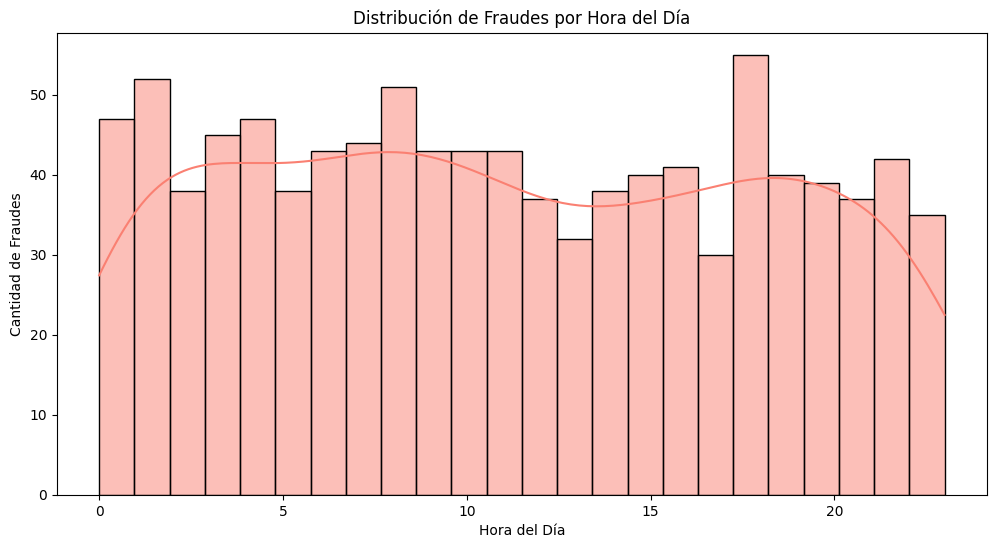

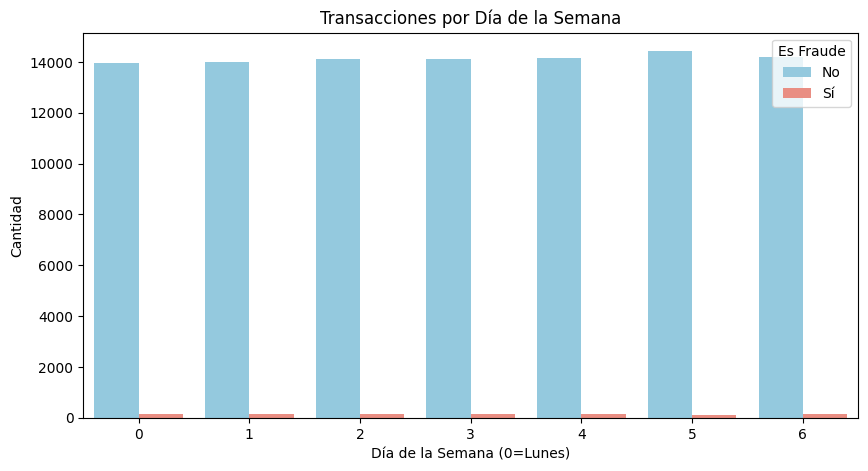

In [8]:
#Extraer componentes temporales
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data['Hour'] = data['TransactionDate'].dt.hour
data['Day'] = data['TransactionDate'].dt.day
data['Month'] = data['TransactionDate'].dt.month
data['DayOfWeek'] = data['TransactionDate'].dt.dayofweek

#Fraude por hora del día
plt.figure(figsize=(12, 6))
sns.histplot(data=data[data['IsFraud']==1], x='Hour', bins=24, 
                kde=True, color='salmon')
plt.title('Distribución de Fraudes por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Cantidad de Fraudes')
plt.show()

#Fraude por día de la semana
plt.figure(figsize=(10, 5))
sns.countplot(x='DayOfWeek', hue='IsFraud', data=data, 
                palette=['skyblue', 'salmon'])
plt.title('Transacciones por Día de la Semana')
plt.xlabel('Día de la Semana (0=Lunes)')
plt.ylabel('Cantidad')
plt.legend(title='Es Fraude', labels=['No', 'Sí'])
plt.show()

**Distribución del Monto en Transacciones Fraudulentas**

           count        mean          std   min        25%      50%       75%  \
IsFraud                                                                         
0        99000.0  2496.88992  1442.257175  1.05  1247.9550  2495.61  3742.855   
1         1000.0  2517.16444  1458.643653  5.56  1249.2775  2543.43  3813.850   

             max  
IsFraud           
0        4999.77  
1        4985.88  


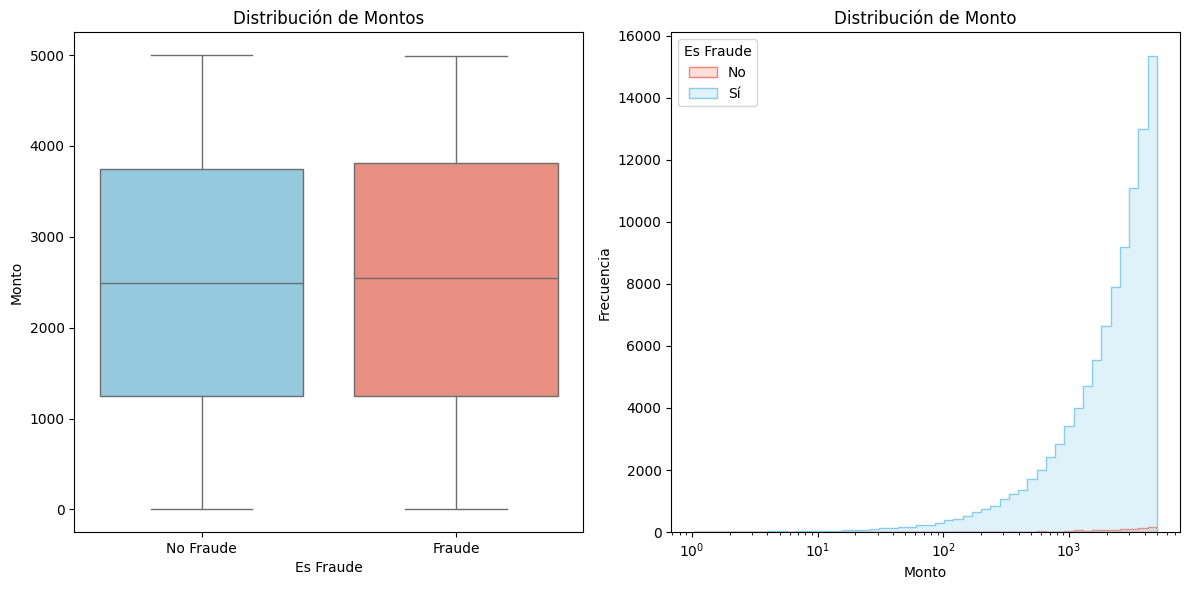

In [9]:
print(data.groupby('IsFraud')['Amount'].describe())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='IsFraud', y='Amount', data=data, hue='IsFraud', 
            palette=['skyblue', 'salmon'], showfliers=True, legend=False)
plt.title('Distribución de Montos')
plt.ylabel('Monto')
plt.xlabel('Es Fraude')
plt.xticks([0, 1], ['No Fraude', 'Fraude'])

plt.subplot(1, 2, 2)
sns.histplot(data=data, x='Amount', hue='IsFraud', 
                bins=50, element='step', common_norm=False,
                palette=['skyblue', 'salmon'], log_scale=True)
plt.title('Distribución de Monto')
plt.xlabel('Monto')
plt.ylabel('Frecuencia')
plt.legend(title='Es Fraude', labels=['No', 'Sí'])

plt.tight_layout()
plt.show()

> Las distribuciones son bastante similares en términos generales
> Las medianas y cuartiles sugieren que las transacciones fraudulentas podrían tener montos ligeramente más altos

**Análisis geográfico `Location`:**

¿Hay ciudades con mayor incidencia de fraudes?

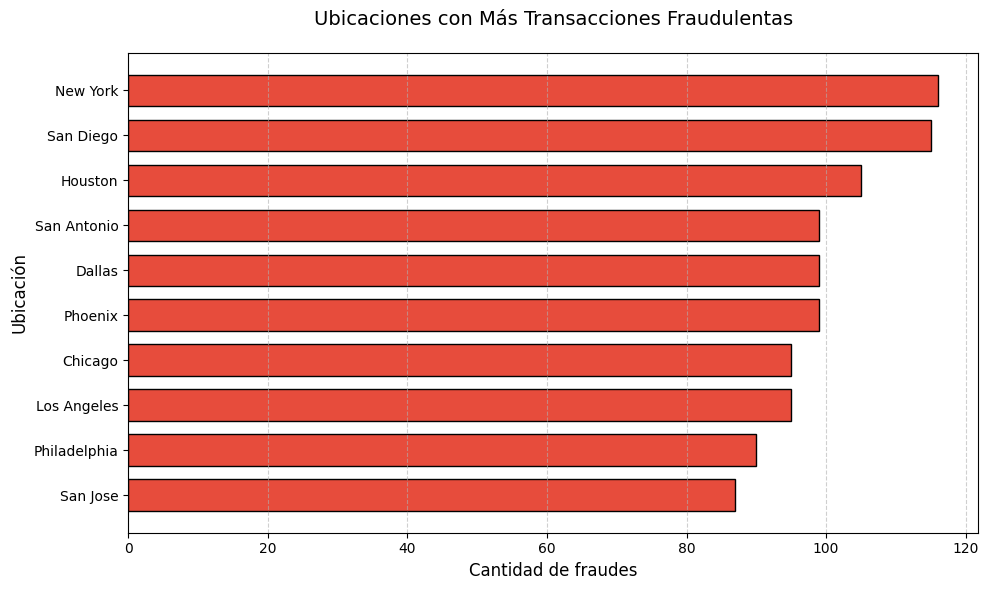

In [10]:
fraud_by_location = data[data['IsFraud'] == 1]['Location'].value_counts().head(10)
plt.figure(figsize=(10, 6))
plt.barh(
    fraud_by_location.index,
    fraud_by_location.values,
    color='#e74c3c',
    height=0.7,
    edgecolor='black'
)
plt.title('Ubicaciones con Más Transacciones Fraudulentas', fontsize=14, pad=20)
plt.xlabel('Cantidad de fraudes', fontsize=12)
plt.ylabel('Ubicación', fontsize=12)
plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

¿Hay comerciantes con mayor incidencia de fraudes?

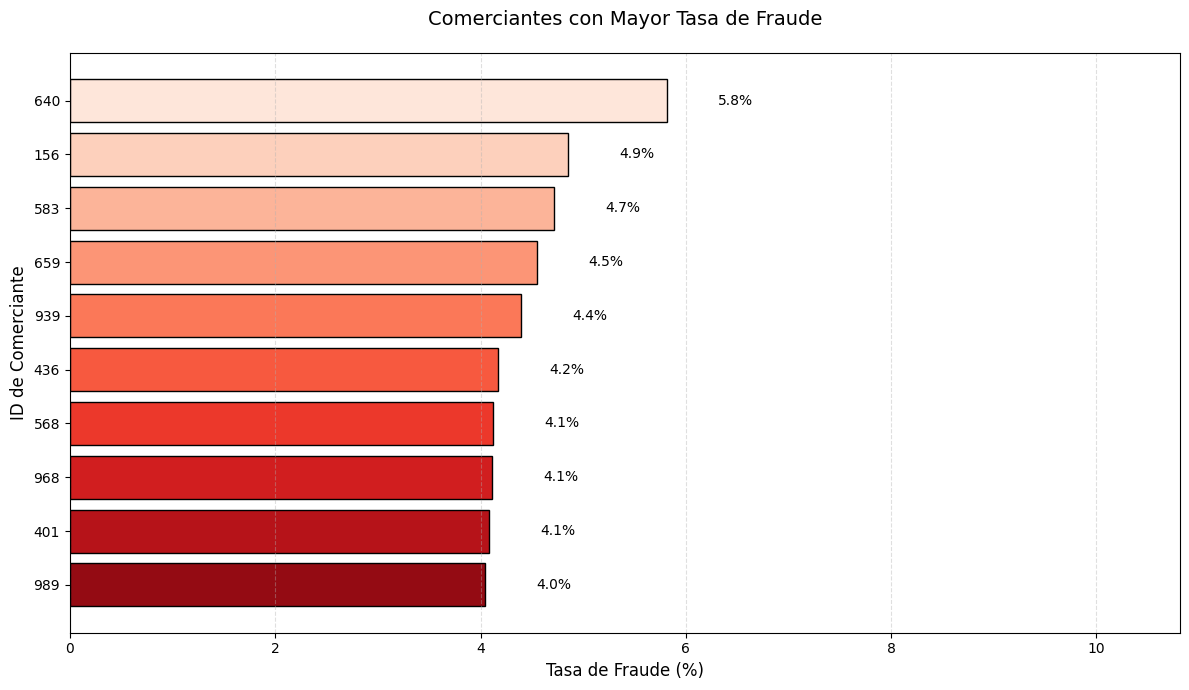

In [11]:
merchant_fraud_rate = (data.groupby('MerchantID')['IsFraud']
                        .mean()
                        .mul(100)  
                        .nlargest(10)
                        .sort_values())

plt.figure(figsize=(12, 7))

bars = plt.barh(merchant_fraud_rate.index.astype(str), merchant_fraud_rate.values,
                color=sns.color_palette('Reds_r', 10), edgecolor='black')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', va='center', fontsize=10)

plt.title('Comerciantes con Mayor Tasa de Fraude', fontsize=14, pad=20)
plt.xlabel('Tasa de Fraude (%)', fontsize=12)
plt.ylabel('ID de Comerciante', fontsize=12)
plt.xlim(0, merchant_fraud_rate.max() + 5)  
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

**Tipos de Transacción:**

- ¿Cuál es la distribución de los tipos de transacción en general?
- ¿Hay algún tipo de transacción **(compra, reembolso)** más asociado al fraude?

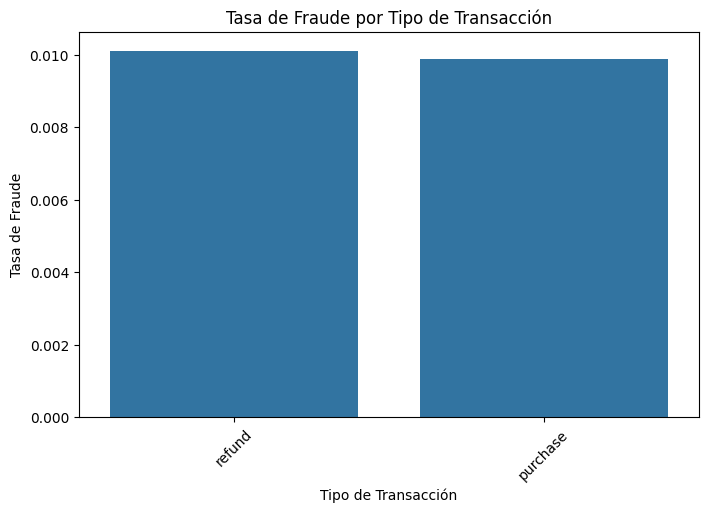

In [12]:
transaction_type_fraud = data.groupby('TransactionType')['IsFraud'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=transaction_type_fraud.index, y=transaction_type_fraud.values)
plt.title('Tasa de Fraude por Tipo de Transacción')
plt.xlabel('Tipo de Transacción')
plt.ylabel('Tasa de Fraude')
plt.xticks(rotation=45)
plt.show()

#### **Balancear dataset**

Debido a que se tiene un dataset con 100000 transacciones donde el 99% de las transacciones son legítimas y el 1% son fraudulentas, se procede a realizar una reducción del las muestras, donde se dejarán solo 10000 transacciones legítimas y todos los fraudes presentes en los datos.

In [ ]:
from utils.process_data import balance_dataset

# Balancear dataset
df_balanced, class_counts = balance_dataset(
    input_path='./data/credit_card_fraud_dataset.csv',
    output_path='./data/dataset_balanceado.csv',
    target_col='IsFraud',
    n_samples=10000
)

df_balanced.head()

Proporción final: 10000 no fraudes vs 1000 fraudes
Nuevo balance: 11000 registros en total


,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
10080,10081,2024-10-02 15:52:35.516068,2401.50,540,refund,Dallas,1
71217,71218,2024-05-22 20:10:35.894414,147.13,280,purchase,San Diego,0
73072,73073,2024-08-14 00:22:35.904646,986.03,956,refund,Phoenix,0
75529,75530,2024-01-14 15:13:35.917183,4522.67,122,refund,Chicago,0
30536,30537,2024-01-23 21:17:35.611377,2066.09,537,refund,Houston,0


## **Preprocesamiento de los Datos**

**Convertir `TransactionDate` a datetime y extraer información relevante como la hora, el día y el mes:**

In [25]:
df_balanced['TransactionDate'] = pd.to_datetime(df_balanced['TransactionDate'])

# Extraer componentes temporales
df_balanced['TransactionHour'] = df_balanced['TransactionDate'].dt.hour
df_balanced['TransactionDay'] = df_balanced['TransactionDate'].dt.day
df_balanced['TransactionMonth'] = df_balanced['TransactionDate'].dt.month

df_balanced.head()

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud,TransactionHour,TransactionDay,TransactionMonth
10080,10081,2024-10-02 15:52:35.516068,2401.50,540,refund,Dallas,1,15,2,10
71217,71218,2024-05-22 20:10:35.894414,147.13,280,purchase,San Diego,0,20,22,5
73072,73073,2024-08-14 00:22:35.904646,986.03,956,refund,Phoenix,0,0,14,8
75529,75530,2024-01-14 15:13:35.917183,4522.67,122,refund,Chicago,0,15,14,1
30536,30537,2024-01-23 21:17:35.611377,2066.09,537,refund,Houston,0,21,23,1


**Eliminar Columnas No Relevantes:**

El id de la transacción es información irrelevante que no aporta nada al igual que el id del comerciante, además como de la fecha `TransactionID` ya se extrajo la información necesaria se puede eliminar. 

In [26]:
features_to_drop = ['TransactionID', 'TransactionDate', 'MerchantID']
df_processed = df_balanced.drop(columns=features_to_drop)

df_processed.head()

,Amount,TransactionType,Location,IsFraud,TransactionHour,TransactionDay,TransactionMonth
10080,2401.50,refund,Dallas,1,15,2,10
71217,147.13,purchase,San Diego,0,20,22,5
73072,986.03,refund,Phoenix,0,0,14,8
75529,4522.67,refund,Chicago,0,15,14,1
30536,2066.09,refund,Houston,0,21,23,1


**Codificación de variables categóricas:**

Las variables como `TransactionType` y `Location` son variables categóricas (texto), los modelos de ML no trabajan con texto, lo que implica que estas variables deben convertirse a números.

- Como `TransactionType` solo toma dos posibles valores: refund (reembolso) y purchase (compra) se puede utilizar la codificación **One-Hot Encoding**, donde cada categoría se convierte en una nueva columna binaria, 1 si la categoría está presente, 0 en caso contario. 

- `Location` al tener pocas localidades (10) también se codificará con **One-Hot Encoding**.

In [29]:
#cantidad de localizaciones
unique_locations = df_processed['Location'].nunique()
print(f"El dataset contiene {unique_locations} localizaciones:\n")

print(df_balanced['Location'].unique())

El dataset contiene 10 localizaciones:

['Dallas' 'San Diego' 'Phoenix' 'Chicago' 'Houston' 'Los Angeles'
 'Philadelphia' 'San Antonio' 'San Jose' 'New York']


In [30]:
#drop_first=True es para evitar redundancia (ej. si no es compra, es reembolso).
df_processed = pd.get_dummies(df_processed, columns=['TransactionType', 'Location'], drop_first=True) 
df_processed.head()

,Amount,IsFraud,TransactionHour,TransactionDay,TransactionMonth,TransactionType_refund,Location_Dallas,Location_Houston,Location_Los Angeles,Location_New York,Location_Philadelphia,Location_Phoenix,Location_San Antonio,Location_San Diego,Location_San Jose
10080,2401.50,1,15,2,10,True,True,False,False,False,False,False,False,False,False
71217,147.13,0,20,22,5,False,False,False,False,False,False,False,False,True,False
73072,986.03,0,0,14,8,True,False,False,False,False,False,True,False,False,False
75529,4522.67,0,15,14,1,True,False,False,False,False,False,False,False,False,False
30536,2066.09,0,21,23,1,True,False,True,False,False,False,False,False,False,False


**Separar las características de entrada (input) de la variable objetivo (output: `Isfraud`)**

In [ ]:
X = df_processed.drop('IsFraud', axis=1)
y = df_processed['IsFraud']

**División estratificada de los datos: `train` - `validation` - `test`:**

In [32]:
#Se utiliza stratify=y para mantener la proporción de fraudes
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)

**Estandarización de Variables Numéricas:**

Como el conjunto de datos contiene columnas con valores numéricos, primero debemos estandarizar esos datos, con el propósito de hacer que todos los atributos numéricos estén en una escala común, debido a que los modelos basados en distancia como **Regresión Logística** y **SVM** son sensibles a las escalas.

- La variables `Amount`(Monto) presenta diferentes escalas (147.13 a 4522.67) por lo que es necesario estandarizarla.

- `TransactionHour` es una medida ordinal continua, aunque va de 0 a 23, conceptualmente 23:59 está más cerca de 0:00 que de 12:00 (es circular), para un modelo, la distancia entre 23 y 0 sería 23, cuando en realidad es 1 hora


> **Nota:**
> La normalización se realiza después de haber realizado la división estratrificada para evitar la fuga de datos.
> - El StandardScaler calcula la media (μ) y la desviación estándar (σ) de los datos y luego aplica la fórmula (x - μ) / σ a cada valor.
> - Esto significa que la información del conjunto de prueba (su media, su distribución) se `filtra` al conjunto de entrenamiento y de validación, es decir, el modelo ya tiene conocimiento previo sobre cómo son los datos de prueba y validación antes de verlo, lo que haría que funcione bien pero que cuando se despliegue al mundo real con datos reales tenga un mal rendimiento.

In [242]:
scaler = StandardScaler()

X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
X_val['Amount'] = scaler.transform(X_val[['Amount']])
X_test['Amount'] = scaler.transform(X_test[['Amount']])